# Biased autoencoder su dati RNA-Seq

Allo scopo di migliorare la compressione, costruiamo una rete neurale simile ad un autoencoder, dove sostituiamo la componente decoder con un classificatore. Anziché performare una ricostruzione dei dati, effettuiamo una classificazione di essi. Utilizzeremo poi la componente encoder per comprimere il dataset.

In [1]:
import pandas as pd 
import numpy  as np

from modules import autoencoder as ae 
from modules import ngs 
from modules import utilities
from modules import postprocess

Salviamo il nome del file contente il dataset.

In [2]:
dataset_file = ngs.get_data_sources()[1]

Salviamo il nome della cartella che conterrà i risultati.

In [27]:
results_directory = 'results/ngs/bias'

## SubBIA: Subtype BIased Autoencoder

Utilizziamo il sottotipo di tumore al seno per veicolare la compressione dei dati. Utilizziamo la funzione `ngs.get_samples_with_label`, che ci permette di inserire, per ogni campione, la relativa label specificata come parametro. Inoltre tale funzione elimina automaticamente ogni record la cui label risutla non definita.

In [4]:
df = ngs.get_samples_with_label('SUBTYPE')
df.head()

,100133144,100134869,10357,10431,155060,26823,280660,340602,388795,390284,SUBTYPE
TCGA-3C-AAAU-01,1.0625,1.4054,-2.6318,-2.3685,3.9877,-2.1170,-4.3428,1.2983,-1.2612,-0.7965,BRCA_LumA
TCGA-3C-AALI-01,0.3242,1.8883,-1.1750,-0.9363,2.1972,0.2431,-0.2931,14.2840,1.7157,-2.3744,BRCA_Her2
TCGA-3C-AALJ-01,0.6145,0.8671,2.8280,2.9686,2.4923,-2.1170,-4.3428,-1.9741,0.7886,-1.5576,BRCA_LumB
TCGA-3C-AALK-01,0.6655,1.1569,2.4738,0.9625,2.3449,-1.0068,-4.3428,-1.9741,0.4009,-0.6131,BRCA_LumA
TCGA-4H-AAAK-01,-0.0534,1.5834,-0.2282,0.4232,0.7330,-0.9801,-4.3428,-0.8161,0.9240,-1.3989,BRCA_LumA


## Preparazione dei dati di training

In [5]:
nclasses = len(df['SUBTYPE'].unique())
print(f"Non considerando la classe nulla, vi sono {nclasses} classi")

Non considerando la classe nulla, vi sono 5 classi


Partizioniamo il dataset, facendo attenzione al problema del campionamento per la classificazione multiclasse. 
È necessario utilizzare un label encoder per convertire la label SUBTYPE in un valore categoriale.

In [16]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

npoints, nfeatures = df.shape
nfeatures -= 1 # remove the subtype count from the features
train_set, valid_set =  utilities.multilabel_train_test_split(df, 'SUBTYPE', .2)
train_set, test_set  =  utilities.multilabel_train_test_split(train_set,   'SUBTYPE', .2)

label_encoder = LabelEncoder()
label_encoder.fit(df['SUBTYPE'].unique())

takex = lambda _ds: _ds.drop(['SUBTYPE'], axis=1)
takey = lambda _ds: to_categorical(label_encoder.transform(_ds['SUBTYPE']))
x_train, x_test, x_valid = takex(train_set), takex(test_set), takex(valid_set) 
y_train, y_test, y_valid = takey(train_set), takey(test_set), takey(valid_set)

### Costruzione del modello

In [17]:
autoencoder_structure = ae.biased_autoencoder(nclasses).get('SubBIA')

In [18]:
enc = autoencoder_structure.get('encoder')
clf = autoencoder_structure.get('classifier')
SubBIA = ae.generate_biased_autoencoder(nfeatures, enc, clf)

Epoch 1/5
3/3 [==============================] - 8s 2s/step - loss: 2.0881 - accuracy: 0.2512 - val_loss: 2.2490 - val_accuracy: 0.1720
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 1.5746 - accuracy: 0.3559 - val_loss: 3.2621 - val_accuracy: 0.1720
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.4413 - accuracy: 0.4775 - val_loss: 3.5592 - val_accuracy: 0.1720
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.3688 - accuracy: 0.5018 - val_loss: 3.1516 - val_accuracy: 0.1911
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.3170 - accuracy: 0.5251 - val_loss: 2.4945 - val_accuracy: 0.2038


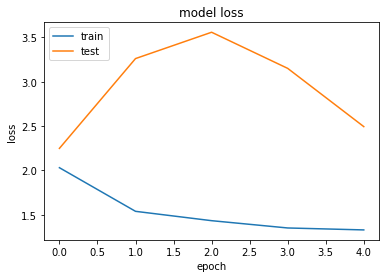

In [19]:
from keras.callbacks import EarlyStopping

earlystopping = EarlyStopping(monitor='val_loss',\
                              verbose=1, patience=40,\
                              restore_best_weights=True)

SubBIA_history = SubBIA.fit(np.asarray(x_train).astype(np.float32), y_train,
            epochs=60, 
            batch_size=256,
            shuffle=True,
            verbose=1,
            callbacks=[earlystopping],
            validation_data=(np.asarray(x_test).astype(np.float32), y_test))

postprocess.plot_history(SubBIA_history)

### Valutazione del modello SubBIA

In [22]:
loss, acc = SubBIA.evaluate(np.asarray(x_valid).astype(np.float32), y_valid, verbose=0)
loss, acc

(2.6772401332855225, 0.18877550959587097)

### Salvataggio dei dataset compressi

In [25]:
encpos = autoencoder_structure.get('encoder_position')

ds = df.drop('SUBTYPE', axis=1)

enc150f = ae.extract_encoder(SubBIA, encpos.get(150))
red_ds_150 = pd.DataFrame(enc150f.predict(np.asarray(ds).astype('float32')))
red_ds_150.index = ds.index

enc50f = ae.extract_encoder(SubBIA, encpos.get(50))
red_ds_50 = pd.DataFrame(enc50f.predict(np.asarray(ds).astype('float32')))
red_ds_50.index = ds.index

enc25f = ae.extract_encoder(SubBIA, encpos.get(25))
red_ds_25 = pd.DataFrame(enc25f.predict(np.asarray(ds).astype('float32')))
red_ds_25.index = ds.index

In [28]:
postprocess.save_compressed_dataset(red_ds_150, loss, results_directory, dataset_file)
postprocess.save_compressed_dataset(red_ds_50,  loss, results_directory, dataset_file)
postprocess.save_compressed_dataset(red_ds_25,  loss, results_directory, dataset_file)